# **Section 1. Project Definition** 

## **1.1. Project Overview:**

**1.1.1. problem domain**: <br>
Streaming businesses like Spotify, Pandora, or Netflix often provide services to customers on a month-to-month basis, which is more seductive for them. Customers can use the high-quality services at a low cost and have a secure feeling that they can cancel the service anytime if unsatisfied. 

However, this autonomy could be a burden for the service providers. Streaming businesses often undergo a high turnover of users. Correctly predicting which customers are likely to cancel the service could minimize the churn rate, which would be valuable to the business. It is a well-known fact that the cost of acquiring a new customer is often much higher than retaining an existing one. If such users are accurately identified in advance, service providers can offer them incentives for staying and potentially save millions in revenues.

To help boosting the streaming businesses, this project tried to tackle the abovementioned problems through machine learning techniques. <br><br>

**1.1.2. project origin**: <br>
Sparkify is a fictitious music streaming service, created by Udacity to resemble the large datasets generated by companies such as Spotify. Millions of users stream songs with the services daily, either using a free tier that plays advertisements between songs or using a premium subscription model, where users pay a monthly flat rate. Users can upgrade or downgrade their subscription plan anytime but can also cancel it.

Whenever a user interacts with this music streaming app, whether playing songs, adding them to playlists, rating them with a thumbs up or down, adding a friend, logging in or out, changing settings, etc., data is generated. User activity logs contain key insights for helping the business providers understand whether users are satisfied with the service. <br><br>

**1.1.3. datasets:** <br>
Two datasets were provided:

1. A mini 128MB dataset with 225 unique users that we’ve used to explore and get an understanding of the dataset’s characteristics and features (286K rows)

2. A large 12GB dataset with 22K unique users, which we used Spark and the big data Hadoop framework to finish the analysis and modeling due to its' massive size (26M rows).


## **1.2. Problem Statements:**

**1.2.1. core problem:** <br>
The crucial part is how to predict users who are going to churn. A churned user was defined as “users who have submitted the confirmation of cancellation". Considering that the service provider still can make revenue from the advertiser in this case, we did not treat users submitting a confirmation of downgrade as churned users. <br><br>

**1.2.2. strategy for solving:** <br>
The strategy comprises four main steps summarized as follows:

Step 1. Data Understanding

&nbsp;&nbsp;&nbsp;&nbsp;a. Comprehends the meanings of values in different columns<br>
&nbsp;&nbsp;&nbsp;&nbsp;b. Checks if any inappropriate data types<br>
&nbsp;&nbsp;&nbsp;&nbsp;c. Checks if any abnormalities (missing values, duplicates etc.)<br><br>

Step 2. Data Preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;a. Obtains user-level information or statistics through mapping (e.g. user’s gender, start/end of the observation period, etc.) or aggregation (e.g. song count, advertisement count, etc.)<br>
&nbsp;&nbsp;&nbsp;&nbsp;b. Engineers extra features for helping identify churned users e.g. aggregated statistics per unit of time.<br>
&nbsp;&nbsp;&nbsp;&nbsp;c. Defines the binary response variable: 1 — users who canceled the subscription within the observation period, and 0 — users who kept the service throughout the period<br>
&nbsp;&nbsp;&nbsp;&nbsp;d. Analyzes the correlation between engineered features and ensure there are no highly correlated features<br>
&nbsp;&nbsp;&nbsp;&nbsp;e. Through visualizations, identify and remove the features not having enough information for distinguishing the groups of churned and non-churned users<br><br>

Step 3. Modeling and Initial Evaluation

&nbsp;&nbsp;&nbsp;&nbsp;a. Splits the dataset into training and test set<br>
&nbsp;&nbsp;&nbsp;&nbsp;b. Defines pipelines that combine a vector assembler, a scaler for numerical features, and a selected binary classifier<br>
&nbsp;&nbsp;&nbsp;&nbsp;c. Trains these pipelines and evaluates their performance on the test set with the PR-AUC score.<br>
&nbsp;&nbsp;&nbsp;&nbsp;d. By comparing their PR-AUC score selects the best model for further tunning.<br><br>

Step 4. Refinement and Final Evaluation

&nbsp;&nbsp;&nbsp;&nbsp;a. Through grid search with cross-validation (using PR-AUC), find the best combination of hyperparameters for the selected model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;b. Analyzes the feature importance and identifies the optimal feature combination that maintains or improves the generalization of the model.<br>
&nbsp;&nbsp;&nbsp;&nbsp;c. Identifies the optimal threshold of the classifier.<br>
&nbsp;&nbsp;&nbsp;&nbsp;d. If the ratio of classes is imbalanced, different weights should be assigned to the classes accordingly.<br>
&nbsp;&nbsp;&nbsp;&nbsp;e. Re-trained the classifier with the optimal hyper-parameters, optimal feature combination, prediction threshold, and weights of classes.<br><br>

The abovementioned steps illustrate the end-to-end model development process that will be first performed on the mini Sparkify dataset. The steps are discussed in detail in Sections 2–4. As mentioned already, the best-performing model will be eventually trained and tested on the full dataset. This will be done by simply rerunning the developed code on the full dataset, using an EMR cluster. Corresponding results are presented in Section 5. <br><br>

**1.2.3. discussion of the expected solution:**<br>
The solution is expected to have the highest metric score among the candidates of the classification algorithms. If possible, a lower training time is also preferred. In a real-world context, the dataset could be much larger than 12GB. A more efficient algorithm would greatly shorten the time needed by the model tuning process.


## **1.3. Metrics:**

Churn prediction is a supervised binary classification problem. In both datasets, the proportions of churned users are around 23%. Since the imbalanced characteristic, the adopted metric has to strike a balance between precision and recall. F1-score, which is the harmonic mean of precision and recall, could be suitable for this case. 

However, the BinaryClassificationEvaluator() from Spark library only accepts the area under the receiver operating characteristic curve (ROC-AUC) or the area under the precision-recall curve (PR-AUC) as metrics for its pipeline optimization. PR-AUC is the area under a curve of Recall (x-axis) vs Precision (y-axis), which summarizes the model’s performance over every possible threshold. PR-AUC works well for imbalanced datasets and the larger PR-AUC is the better the model performance is. Thus, it is sensible to use PR-AUC as the optimization metric.

When the best-performing model instance is identified and model tunning is finished, we could evaluate the model’s performance on the test set using the F1-score.


# **Section 2: Data Understanding** 

In this section, the mini dataset file, `mini_sparkify_event_data.json`, was explored

## 2.0_Set up Spark Workspace

In [8]:
# import libraries
from pyspark.sql import SparkSession

In [9]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## 2.1_Import packages

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from pyspark.sql import Window
from pyspark.sql.functions import udf, col, desc, when, lit
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, avg, count as Fcount, first, last
from pyspark.sql.types import IntegerType, DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MaxAbsScaler, \
                               StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC, \
                                      MultilayerPerceptronClassifier,\
                                      RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
                                  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.functions import vector_to_array

## 2.2_fetch raw data

In [11]:
# Read in mini sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.createOrReplaceTempView("df_table")

In [12]:
# display columns in df
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [13]:
# Re-order columns in df and create a temporary table for SQL
df =\
spark.sql('''
          SELECT userId, registration, firstName, lastName, gender, location, userAgent, 
                 level, ts, sessionId, page, auth, itemInSession, method, status,
                 song, length, artist
          FROM df_table
''')

df.createOrReplaceTempView("df_table")

## 2.3_have a look at data & check data types

In [ ]:
# data in the mini dataset
print(f'The mini dataset has {df.count()} logs and {len(df.columns)} columns \n')
df.show(3)

The mini dataset has 286500 logs and 18 columns 

+------+-------------+---------+--------+------+--------------------+--------------------+-----+-------------+---------+--------+---------+-------------+------+------+-----------------+---------+----------------+
|userId| registration|firstName|lastName|gender|            location|           userAgent|level|           ts|sessionId|    page|     auth|itemInSession|method|status|             song|   length|          artist|
+------+-------------+---------+--------+------+--------------------+--------------------+-----+-------------+---------+--------+---------+-------------+------+------+-----------------+---------+----------------+
|    30|1538173362000|    Colin| Freeman|     M|     Bakersfield, CA|Mozilla/5.0 (Wind...| paid|1538352117000|       29|NextSong|Logged In|           50|   PUT|   200|        Rockpools|277.89016|  Martha Tilston|
|     9|1538331630000|    Micah|    Long|     M|Boston-Cambridge-...|"Mozilla/5.0 (Win...| free|15

In [ ]:
# data types in df
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- firstName: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- level: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- page: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- song: string (nullable = true)
 |-- length: double (nullable = true)
 |-- artist: string (nullable = true)



## 2.4_have a **closer** look at columns

### 2.4.1_user-level columns(userId, firstName, gender, lastName, level, location, registration & userAgent)

In [ ]:
# Basic investigation into the 'userId' column
# The empty string in 'userId' columns were noticed.
# So, there are 225 unique users
spark.sql('''
          SELECT COUNT(DISTINCT(userId)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT userId, COUNT(*) AS count 
            FROM df_table
          GROUP BY userId
          ORDER BY count DESC
''').show(n = 10)

+-----+
|count|
+-----+
|  226|
+-----+

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
+------+-----+
only showing top 10 rows



In [ ]:
# Basic investigation into the 'firstName' column
# There are 189 unique first name in the mini dataset
spark.sql('''
          SELECT COUNT(DISTINCT(firstName)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT firstName, COUNT(*) AS count 
            FROM df_table
          GROUP BY firstName
          ORDER BY count DESC
''').show(n = 10)

+-----+
|count|
+-----+
|  189|
+-----+

+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 9632|
|     null| 8346|
|    Riley| 7970|
|   Lucero| 6880|
|   Emilia| 5732|
|     Emma| 5478|
|   Joseph| 5209|
|    Colin| 4989|
|   Nicole| 4825|
|   Joshua| 4654|
+---------+-----+
only showing top 10 rows



In [ ]:
# Basic investigation into the 'gender' column
# Below shows how many male and female users are in the mini dataset
spark.sql('''
          SELECT gender, COUNT(*) AS count 
            FROM df_table
            GROUP BY gender
            ORDER BY count DESC
''').show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



In [ ]:
# Basic investigation into the 'lastName' column
# There are 173 unique first name in the mini dataset
spark.sql('''
          SELECT COUNT(DISTINCT(lastName)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT lastName, COUNT(*) AS count 
            FROM df_table
          GROUP BY lastName
          ORDER BY count DESC
''').show(n = 10)

+-----+
|count|
+-----+
|  173|
+-----+

+--------+-----+
|lastName|count|
+--------+-----+
|Campbell|14060|
|    Reed| 9284|
|Williams| 8410|
|    null| 8346|
|  Taylor| 7230|
| Johnson| 6106|
|  Larson| 6105|
|   House| 5732|
|Thompson| 5217|
|   Jones| 4831|
+--------+-----+
only showing top 10 rows



In [ ]:
# Basic investigation into the 'level' column
# Below shows how many users in the mini dataset were using the service 
# with free and paid plans respectively.
spark.sql('''
          SELECT level, COUNT(*) AS count 
            FROM df_table
          GROUP BY level
          ORDER BY count DESC
''').show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



In [ ]:
# Basic investigation into the 'location' column
# Users in the mini dataset come from 114 unique locations.
spark.sql('''
          SELECT COUNT(DISTINCT(location)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT location, COUNT(*) AS count 
            FROM df_table
            GROUP BY location
            ORDER BY count DESC
''').show(n = 10, truncate = False)

+-----+
|count|
+-----+
|  114|
+-----+

+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|Los Angeles-Long Beach-Anaheim, CA         |30131|
|New York-Newark-Jersey City, NY-NJ-PA      |23684|
|Boston-Cambridge-Newton, MA-NH             |13873|
|Houston-The Woodlands-Sugar Land, TX       |9499 |
|null                                       |8346 |
|Charlotte-Concord-Gastonia, NC-SC          |7780 |
|Dallas-Fort Worth-Arlington, TX            |7605 |
|Louisville/Jefferson County, KY-IN         |6880 |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD|5890 |
|Chicago-Naperville-Elgin, IL-IN-WI         |5114 |
+-------------------------------------------+-----+
only showing top 10 rows



In [ ]:
# Basic investigation into the 'registration' column
# Given that DISTINCT() does not treat null as a distinct instance,
# there are 225 unique registration dates.
# Which matches the number of unique users.
# The 'oldest' user registered the account at 13:44:35 on 2018-03-18
# The 'latest' user registered the account at 15:49:14 on 2018-11-26
spark.sql('''
          SELECT COUNT(DISTINCT(registration)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT from_unixtime(MIN(registration) / 1000) AS earliest_reg_date,
                 from_unixtime(MAX(registration) / 1000) AS latest_reg_date
            FROM df_table
''').show()

+-----+
|count|
+-----+
|  225|
+-----+

+-------------------+-------------------+
|  earliest_reg_date|    latest_reg_date|
+-------------------+-------------------+
|2018-03-18 13:44:35|2018-11-26 15:49:14|
+-------------------+-------------------+



In [ ]:
# Basic investigation into the 'userAgent' column
# There are 56 unique agents used by the users in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(userAgent)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT userAgent, COUNT(*) AS count 
            FROM df_table
            GROUP BY userAgent
            ORDER BY count DESC
''').show(n = 15, truncate = False)

+-----+
|count|
+-----+
|   56|
+-----+

+----------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                         |count|
+----------------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                   |22751|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"           |19611|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"        |18448|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"  

### 2.4.2_log-level columns(auth, itemInSession, method, page, sessionId, status, ts)

In [ ]:
# Basic investigation into the 'auth' column
# There are 4 different authentication levels, 
# namely 'Logged In', 'Logged Out', 'Guest', 'Cancelled',
# in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(auth)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT auth, COUNT(*) AS count 
            FROM df_table
            GROUP BY auth
            ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|    4|
+-----+

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [ ]:
# Basic investigation into the 'itemInSession' column
# There are 1322 unique values of itemInSession in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(itemInSession)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT itemInSession, COUNT(*) AS count 
            FROM df_table
            GROUP BY itemInSession
            ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
| 1322|
+-----+

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            0| 3278|
|            1| 3125|
|            2| 3067|
|            3| 3013|
|            4| 2977|
|            5| 2925|
|            6| 2886|
|            7| 2857|
|            8| 2816|
|            9| 2771|
|           10| 2717|
|           11| 2672|
|           12| 2636|
|           13| 2600|
|           14| 2561|
|           15| 2523|
|           16| 2497|
|           17| 2461|
|           18| 2417|
|           19| 2381|
+-------------+-----+
only showing top 20 rows



In [ ]:
# Basic investigation into the 'method' column
# There are 2 different HTTP request method
# namely 'PUT', 'GET',
# in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(method)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT method, COUNT(*) AS count 
            FROM df_table
            GROUP BY method
            ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|    2|
+-----+

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



In [ ]:
# Basic investigation into the 'page' column
# There are 22 unique types of interactions in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(page)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT page, COUNT(*) AS count 
            FROM df_table
            GROUP BY page
            ORDER BY count DESC
''').show(n = 22, truncate = False)

+-----+
|count|
+-----+
|   22|
+-----+

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



In [ ]:
# Basic investigation into the 'sessionId' column
# There are 2,354 unique season IDs in the mini dataset.
# It was observed that different users may share the same season ID.
spark.sql('''
          SELECT COUNT(DISTINCT(sessionId)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT sessionId, COUNT(*) AS count 
            FROM df_table
            GROUP BY sessionId
            ORDER BY count DESC
''').show(n = 5)

spark.sql('''
          SELECT sessionId, userId, COUNT(*) AS count 
            FROM df_table
            GROUP BY sessionId, userId
            ORDER BY sessionId ASC
''').show(n = 5)

+-----+
|count|
+-----+
| 2354|
+-----+

+---------+-----+
|sessionId|count|
+---------+-----+
|     1840| 1322|
|      316| 1247|
|      236|  905|
|      635|  890|
|      368|  799|
+---------+-----+
only showing top 5 rows

+---------+------+-----+
|sessionId|userId|count|
+---------+------+-----+
|        1|100001|   51|
|        1|      |   34|
|        1|300001|  201|
|        1|     2|  428|
|        2|200002|    7|
+---------+------+-----+
only showing top 5 rows



In [ ]:
# Basic investigation into the 'status' column
# There are 3 different HTTP status codes 
# namely '200', '307', '404',
# in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(status)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT status, COUNT(*) AS count 
            FROM df_table
            GROUP BY status
            ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|    3|
+-----+

+------+------+
|status| count|
+------+------+
|   200|259812|
|   307| 26430|
|   404|   258|
+------+------+



In [ ]:
# Basic investigation into the 'ts' column
# The observation window were infered as '2018-10-01 00:00:00 to 2018-11-30 23:59:59'
spark.sql('''
          SELECT from_unixtime(MIN(ts) / 1000) AS observation_start_date,
                 from_unixtime(MAX(ts) / 1000) AS observation_end_date
            FROM df_table
''').show()

+----------------------+--------------------+
|observation_start_date|observation_end_date|
+----------------------+--------------------+
|   2018-10-01 00:01:57| 2018-12-03 01:11:16|
+----------------------+--------------------+



### 2.4.3_song-level columns(artist, length, song)

In [ ]:
# Basic investigation into 'artist' columns
# There are 17655 unqiue artists in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(artist)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT artist, COUNT(*) AS count 
            FROM df_table
          GROUP BY artist
          ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|17655|
+-----+

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Basic investigation into 'length' columns
# There are 14865 unqiue values of song length in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(length)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT length, COUNT(*) AS count 
            FROM df_table
          GROUP BY length
          ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|14865|
+-----+

+---------+-----+
|   length|count|
+---------+-----+
|     null|58392|
| 239.3073| 1205|
|348.57751| 1037|
|201.79546|  908|
|655.77751|  730|
|277.15873|  645|
|219.66322|  585|
|224.67873|  522|
|220.89098|  511|
|236.09424|  450|
|252.21179|  438|
|233.69098|  436|
|122.04363|  412|
|195.94404|  408|
|181.21098|  384|
|225.17506|  379|
|231.81016|  378|
|216.76363|  362|
|302.05342|  345|
|233.89995|  314|
+---------+-----+
only showing top 20 rows



In [ ]:
# Basic investigation into 'song' columns
# There are 58480 unqiue names of songs in the mini dataset.
spark.sql('''
          SELECT COUNT(DISTINCT(song)) AS count 
            FROM df_table
''').show()

spark.sql('''
          SELECT song, COUNT(*) AS count 
            FROM df_table
          GROUP BY song
          ORDER BY count DESC
''').show()

+-----+
|count|
+-----+
|58480|
+-----+

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



## 2.5_Abnormalities Check

### 2.5.1_check duplicated data

In [ ]:
# Check if any duplicated data in df.
# We counted the number of distinct logs and
# found that the number matched with the total number of logs. 
# Thus, there were NO duplicated logs in the datasets.
spark.sql('''
          WITH table_1 AS (
                           SELECT DISTINCT *
                           FROM df_table
          )

          SELECT COUNT(*) AS num_of_unique_log
          FROM table_1
''').show()

+-----------------+
|num_of_unique_log|
+-----------------+
|           286500|
+-----------------+



### 2.5.2_check missing values & duplicated data

In [ ]:
# count the number of null value in columns
print("Missing values in columns:\n")
for column in df.columns:
    print( f"{column}: {df.filter(col(column).isNull()).count()}" )

Missing values in columns:

userId: 0
registration: 8346
firstName: 8346
lastName: 8346
gender: 8346
location: 8346
userAgent: 8346
level: 0
ts: 0
sessionId: 0
page: 0
auth: 0
itemInSession: 0
method: 0
status: 0
song: 58392
length: 58392
artist: 58392


In [ ]:
# count the number of missing values in the form of empty string - ""
print('Missing values in the form of empty string - "" in columns:\n')

for column in df.columns:
    print( f"{column}: {df.filter(col(column) == '').count()}" )

Missing values in the form of empty string - "" in columns:

userId: 8346
registration: 0
firstName: 0
lastName: 0
gender: 0
location: 0
userAgent: 0
level: 0
ts: 0
sessionId: 0
page: 0
auth: 0
itemInSession: 0
method: 0
status: 0
song: 0
length: 0
artist: 0


In [ ]:
# The columns with 8,346 missing values or empty strings, 
# i.e. ‘firstName’, ‘gender’, ‘lastName’, ‘location’, ‘registration’, ‘userAgent’, ‘userId’, 
# are all from the same logs. 
spark.sql('''
          WITH table_1 AS (
                            SELECT *
                              FROM df_table
                              WHERE userId = ""
                                AND registration IS NULL
                                AND firstName IS NULL
                                AND lastName IS NULL
                                AND gender IS NULL
                                AND location IS NULL
                                AND userAgent IS NULL
          )

          SELECT COUNT(*) AS count
            FROM table_1
''').show(n = 50)

+-----+
|count|
+-----+
| 8346|
+-----+



In [ ]:
# The common characteristic of these logs is that
# they are all with authentication levels of ‘Logged Out’ or ‘Guest’
spark.sql('''
          WITH table_1 AS (
                            SELECT *
                              FROM df_table
                              WHERE userId = ""
                                AND registration IS NULL
                                AND firstName IS NULL
                                AND lastName IS NULL
                                AND gender IS NULL
                                AND location IS NULL
                                AND userAgent IS NULL
          )

          SELECT auth, COUNT(*) AS count
            FROM table_1
            GROUP BY auth
''').show(n = 50)

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [ ]:
# The columns with 58,392 missing values or empty strings, 
# i.e. ‘song’, ‘length’, ‘artist’
# are all from the same logs. 
spark.sql('''
          WITH table_1 AS (
                            SELECT *
                              FROM df_table
                              WHERE song IS NULL
                                AND length IS NULL
                                AND artist IS NULL
          )

          SELECT COUNT(*) AS count
            FROM table_1
''').show(n = 50)

+-----+
|count|
+-----+
|58392|
+-----+



In [ ]:
# Song, artist, and length have non-missing values
# only for the ‘NextSong’ interaction type.
spark.sql('''
          WITH table_1 AS (
                            SELECT *
                              FROM df_table
                              WHERE song IS NOT NULL
                                AND length IS NOT NULL
                                AND artist IS NOT NULL
          )

          SELECT page, COUNT(*) AS count
            FROM table_1
            GROUP BY page
''').show(n = 50)

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



### 2.5.3_check other characteristics about the data

In [ ]:
# We can observe that four logs were recorded after November. 
# That only four logs were recorded in three days is evidently unusual.
spark.sql('''
          SELECT userId, registration, firstName, lastName, gender, location, userAgent, 
                 level, from_unixtime(ts/1000) AS ts, sessionId, page, auth, itemInSession, method, status,
                 song, length, artist
          FROM df_table
          ORDER BY ts DESC
''').show(n = 10)

+------+-------------+---------+--------+------+--------------------+--------------------+-----+-------------------+---------+---------------+---------+-------------+------+------+-------------------+---------+----------------+
|userId| registration|firstName|lastName|gender|            location|           userAgent|level|                 ts|sessionId|           page|     auth|itemInSession|method|status|               song|   length|          artist|
+------+-------------+---------+--------+------+--------------------+--------------------+-----+-------------------+---------+---------------+---------+-------------+------+------+-------------------+---------+----------------+
|100002|1529934689000|   Gracie|   Chang|     F|Santa Maria-Santa...|Mozilla/5.0 (Wind...| paid|2018-12-03 01:11:16|      198|       NextSong|Logged In|            0|   PUT|   200|            Lullaby|465.60608|        The Cure|
|200008|1533670697000|  Adriana|   Mayer|     F|Charlotte-Concord...|"Mozilla/5.0 (Win..

# **Section 3: Methodology** 

## 3.1_Data Preprocessing

To construct the appropriate dataset containing labels and selected features for modeling, labels, and several features on per user basis were engineered by using mappings, aggregated statistics, and the one-hot encoding after the processes of data cleaning and wrangling. After calculating the correlation of features and examining the effectiveness of features by visualizations, 16 features were selected to be included in the dataset for model training.

### 3.1.1_data cleaning

As mentioned before, the authentication level of logs with empty ‘userId’ are 'logged out' or 'guests'. These users are not identifiable. In other words, they do not contain any insight for the churn prediction. They can be simply removed.

In Section 2.5.3, we noticed that there are four logs recorded after 23:59 30/11/2018. They are extremely rare compared to the number of logs on other dates. Also, it is more sensible to infer the observation period as exact 2 months rather than 2 months and 3 days. Therefore, we can assume those logs’ timestamps entries were corrupted and can be simply removed.

In [14]:
# Keep the logs that have the non-empty strings and were recorded before December.
df_clean = df.filter( (df["userId"] != "") & (df["ts"] < 1543622400000) )

print(f'After cleaning, {df_clean.count()} logs left')
print(f'After cleaning, {df_clean.select("userId").dropDuplicates().count()} unique users left')

After cleaning, 278150 logs left
After cleaning, 225 unique users left


In [15]:
print("Missing values in columns (after cleaning):\n")

for column in df_clean.columns:
    
    print( f"{column}: {df_clean.filter(col(column).isNull()).count()}" )

Missing values in columns (after cleaning):

userId: 0
registration: 0
firstName: 0
lastName: 0
gender: 0
location: 0
userAgent: 0
level: 0
ts: 0
sessionId: 0
page: 0
auth: 0
itemInSession: 0
method: 0
status: 0
song: 50046
length: 50046
artist: 50046


### 3.1.2_data wrangling

The original values of userAgent columns are in the format like "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36". After some data wrangling steps, only the OS information, e.g., Macintosh, were extracted. The reason is that differences in browsers usually do not cause a great impact on the app development compared to differences between operating systems.

In [16]:
# function for extreacting the OS string
get_agent_operation_system = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Replace the original 'userAgent' column with a column having the OS info only
df_clean_wrangle = df_clean.withColumn("userAgent", get_agent_operation_system("userAgent"))
df_clean_wrangle = df_clean_wrangle.withColumnRenamed("userAgent", "userAgent_OS")

In [17]:
df_clean_wrangle.show(n = 5)

+------+-------------+---------+--------+------+--------------------+------------+-----+-------------+---------+--------+---------+-------------+------+------+--------------------+---------+----------------+
|userId| registration|firstName|lastName|gender|            location|userAgent_OS|level|           ts|sessionId|    page|     auth|itemInSession|method|status|                song|   length|          artist|
+------+-------------+---------+--------+------+--------------------+------------+-----+-------------+---------+--------+---------+-------------+------+------+--------------------+---------+----------------+
|    30|1538173362000|    Colin| Freeman|     M|     Bakersfield, CA|     Windows| paid|1538352117000|       29|NextSong|Logged In|           50|   PUT|   200|           Rockpools|277.89016|  Martha Tilston|
|     9|1538331630000|    Micah|    Long|     M|Boston-Cambridge-...|     Windows| free|1538352180000|        8|NextSong|Logged In|           79|   PUT|   200|         

### 3.1.3_one-hot encoding_1 (churn, gender, last level)

Categorical features must be one-hot encoded so that they can be inputted into the model.

In [18]:
# Define churned users who submitted the confirmation of cancellation.
# 0 and 1 represent non-churned users and churned users respectively.
churn_user_list = df_clean.filter(df_clean.page == "Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [ churn_user['userId'] for churn_user in churn_user_list.collect() ]

get_churn_user = udf(lambda x: 1 if x in churn_user_list else 0, IntegerType())

df_one_hot = df_clean_wrangle.withColumn("churn_bool", get_churn_user('userId'))

In [19]:
# One-hot encode the gender column.
# 0 and 1 represent female and male respectively.
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

df_one_hot = df_one_hot.withColumn("gender", get_gender(df_one_hot.gender))

df_one_hot = df_one_hot.withColumnRenamed("gender", "gender_bool")

In [20]:
# One-hot encode users’ last subscription level within the observation period.
# 0 and 1 represent the free plan and the paid plan respectively.
window_user = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

df_one_hot = df_one_hot.withColumn("level", get_level(last('level').over(window_user)))
df_one_hot = df_one_hot.withColumnRenamed("level", "last_level_bool")

In [21]:
df_one_hot.show(n = 5)

+------+-------------+---------+---------+-----------+--------------------+------------+---------------+-------------+---------+---------+---------+-------------+------+------+--------------------+---------+--------------------+----------+
|userId| registration|firstName| lastName|gender_bool|            location|userAgent_OS|last_level_bool|           ts|sessionId|     page|     auth|itemInSession|method|status|                song|   length|              artist|churn_bool|
+------+-------------+---------+---------+-----------+--------------------+------------+---------------+-------------+---------+---------+---------+-------------+------+------+--------------------+---------+--------------------+----------+
|100010|1538016340000| Darianna|Carpenter|          0|Bridgeport-Stamfo...|      iPhone|              0|1539003534000|       31| NextSong|Logged In|            0|   PUT|   200|Captain Tyin Knot...|202.97098|Sleeping With Sirens|         0|
|100010|1538016340000| Darianna|Carpente

### 3.1.4_basic data visualizations

#### 3.4.1_proportion of churned users and non-churned users

In [22]:
# Define pandas dataframe to visualize 
# the proportion of churned users and non-churned users
pd_pie = df_one_hot.select(['userId', 'churn_bool'])\
                   .dropDuplicates()\
                   .toPandas()

In [23]:
# Number of non-churned users and churned users in the mini dataset
sorted_counts = pd_pie['churn_bool'].value_counts()
sorted_counts

0    173
1     52
Name: churn_bool, dtype: int64

Below is the pie chart that shows the proportions of churned users and non-churned users. Churned users are slightly less than 1/4 of the dataset and the non-churned users is slightly more than 3/4 of the dataset. From the graph, we can tell that the ratio of the classes is imbalanced.

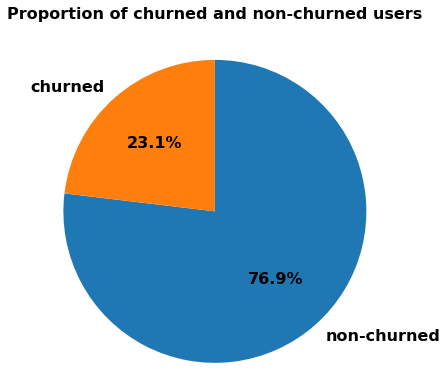

In [24]:
# Through pie chart, 
# visualize the proportion of churned users and non-churned users
fig_1, ax_1 = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6))

pad = 30
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}

ax_1.pie(sorted_counts, \
        labels = ['non-churned', 'churned'], \
        autopct = '%1.1f%%', \
        startangle = 90, \
        counterclock = False, \
        textprops = label_fontdict)

ax_1.axis('equal');

ax_1.set_title('Proportion of churned and non-churned users', \
             fontdict = label_fontdict, \
             pad = pad);

plt.savefig("images/pic_3_2.png", bbox_inches = 'tight');

### 3.1.5_feature engineering

In [ ]:
# Default observation start and end timestamps 
# for users who have registered before October 1 and had not churned
observation_start_default = 1538352000000 # 01/10/2018 00:00:00
observation_end_default = 1543622400000 # 30/11/2018 23:59:59

In [ ]:
# Obtain the observation window of users and the corresponding duration in days.
window_user = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_one_hot = df_one_hot.withColumn("observation_start", \
                                   when(df_one_hot.registration > observation_start_default, df_one_hot.registration)\
                                   .otherwise(observation_start_default))

df_one_hot = df_one_hot.withColumn("last_log_ts", last(col('ts')).over(window_user))

df_one_hot = df_one_hot.withColumn("observation_end", \
                                   when(df_one_hot.churn_bool == 1, df_one_hot.last_log_ts)\
                                   .otherwise(observation_end_default))

df_one_hot = df_one_hot.withColumn("observation_duration_day", \
                                   (df_one_hot.observation_end - df_one_hot.observation_start) / 1000 / 3600 / 24)

In [ ]:
# Aggregation by userId
df_aggregation = \
df_one_hot\
.groupby('userId')\
.agg(
      # Aggregated user-level features
      first(col('churn_bool')).alias('label'),
      first(col('gender_bool')).alias('gender_bool'),
      first(col('last_level_bool')).alias('last_level_bool'),
      first(col('observation_duration_day')).alias('observation_duration_day'),
      
      # Aggregated statistics about interactions
      Fcount(col('page')).alias('interaction_num'),
      Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("song_num"),
      Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("thump_up_num"),
      Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("thump_down_num"),
      Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("add_friend_num"),
      Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("add_playlist_num"),
      Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("submit_downgrade_num"),
      Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("submit_upgrade_num"),
      Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("home_per_num"),
      Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("advertisement_num"),
      Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("help_num"),
      Fsum(when(col('page') == "Settings", 1).otherwise(0)).alias("setting_num"),
      Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("error_num"),
      
      # Aggregated statistics about interactions within a particular period
      Fsum(when(col('ts') < col('observation_start') + (14 * 24 * 3600 * 1000), 1).otherwise(0)).alias("interaction_num_first_14_day"),
      Fsum(when(col('ts') > col('observation_end') - (14 * 24 * 3600 * 1000), 1).otherwise(0)).alias("interaction_num_last_14_day"),
      Fsum(when( (col('page') == "NextSong") & (col('ts') < col('observation_start') + (14 * 24 * 3600 * 1000)), 1 ).otherwise(0)).alias("song_num_first_14_day"),
      Fsum(when( (col('page') == "NextSong") & (col('ts') > col('observation_end') - (14 * 24 * 3600 * 1000)), 1 ).otherwise(0)).alias("song_num_last_14_day"),
     
      # Aggregated statistics of users' "age"
      ((Fmax('ts') - first('registration')) / 1000 / 3600 / 24).alias("day_since_registration")
)

In [ ]:
# Obtain features for the model training
# Convert the above aggregated statistics into specific formats (per unit of time, ratio etc.)
df_engineered_feature = \
df_aggregation\
.withColumn('interaction_per_day', col('interaction_num') / col('observation_duration_day'))\
.withColumn('song_per_day', col('song_num') / col('observation_duration_day'))\
.withColumn('thump_up_per_day', col('thump_up_num') / col('observation_duration_day'))\
.withColumn('thump_down_per_day', col('thump_down_num') / col('observation_duration_day'))\
.withColumn('add_friend_per_day', col('add_friend_num') / col('observation_duration_day'))\
.withColumn('add_playlist_per_day', col('add_playlist_num') / col('observation_duration_day'))\
.withColumn('home_per_day', col('home_per_num') / col('observation_duration_day'))\
.withColumn('advertisement_per_day', col('advertisement_num') / col('observation_duration_day'))\
.withColumn('help_per_day', col('help_num') / col('observation_duration_day'))\
.withColumn('setting_per_day', col('setting_num') / col('observation_duration_day'))\
.withColumn('error_per_day', col('error_num') / col('observation_duration_day'))\
.withColumn('song_ratio', col('song_num') / col('interaction_num'))\
.withColumn( 'positive_ratio', (col('thump_up_num') + col('add_friend_num') + col('add_playlist_num')) / col('interaction_num') )\
.withColumn( 'negative_ratio', (col('thump_down_num') + col('help_num') + col('error_num')) / col('interaction_num') )\
.withColumn( 'thumb_up_down_ratio', col('thump_up_num') / (col('thump_down_num') + 0.0001) )\
.withColumn('plan_change_num', col('submit_upgrade_num') + col('submit_downgrade_num'))\
.withColumn( 'trend_interaction', (col('interaction_num_last_14_day') - col('interaction_num_first_14_day')) / 14 / col('observation_duration_day') )\
.withColumn( 'trend_song', (col('song_num_last_14_day') - col('song_num_first_14_day')) / 14 / col('observation_duration_day') )

In [ ]:
# Filter out the intermediate information
df_engineered_feature = \
df_engineered_feature.select(df_engineered_feature.columns[0:4] + df_engineered_feature.columns[22:])

In [ ]:
# Obtain features for the model training
# Calculation of user's average item in a session and average session length
interaction_pattern_1 = \
df.groupby(['userId', 'sessionId'])\
  .agg(
       Fmax(col('itemInSession')).alias('item_in_session'), 
       ( Fmax(col('ts')) - Fmin(col('ts')) ).alias('session_length')     
  )\
 .groupby('userId')\
  .agg(
       avg(col('item_in_session')).alias('average_session_item'),
       avg(col('session_length')).alias('average_session_length')
  )

In [ ]:
# Obtain features for the model training
# Calculation of user's average number of songs played between two consecutive home visits
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0))

df_dummy = df.withColumn("home_phase", Fsum(when(df.page == "Home", 1).otherwise(0)).over(windowhome))

interaction_pattern_2 = \
df_dummy.groupby(['userId', 'home_phase'])\
        .agg(
             Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias('song_between_home')
        )\
        .groupby('userId')\
          .agg(
               avg(col('song_between_home')).alias('average_song')
          )

In [ ]:
# Join the dataframe of engineered features together
df_engineered_feature = \
df_engineered_feature\
.join(interaction_pattern_1, on = 'userId')\
.join(interaction_pattern_2, on = 'userId')

In [ ]:
df_engineered_feature.show(n = 5)

+------+-----+-----------+---------------+----------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+---------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+---------------+--------------------+--------------------+--------------------+----------------------+------------------+
|userId|label|gender_bool|last_level_bool|day_since_registration|interaction_per_day|      song_per_day|  thump_up_per_day| thump_down_per_day| add_friend_per_day|add_playlist_per_day|       home_per_day|advertisement_per_day|       help_per_day|    setting_per_day|      error_per_day|        song_ratio|     positive_ratio|      negative_ratio|thumb_up_down_ratio|plan_change_num|   trend_interaction|          trend_song|average_session_item|average_session_length|      average_song|
+------+-----+----------

### 3.1.6_one-hot encoding_2 (userAgent_OS)

In [ ]:
# Get necessary infomation from df_one_hot
df_temp = df_one_hot['userId', 'userAgent_OS'].dropDuplicates()

In [ ]:
# Create a dataframe for this one-hot encoding process
df_engineered_feature_2 = df_engineered_feature.join(df_temp, on = 'userId')

In [ ]:
# one-hot encode the 'userAgent_OS' columns
# [1.0, 0.0, 0.0, 0.0, 0.0] : Windows
# [0.0, 0.0, 0.0, 0.0, 0.0] : Macintosh
# [0.0, 0.0, 1.0, 0.0, 0.0] : iPhone
# [0.0, 0.0, 0.0, 1.0, 0.0] : X11
# [0.0, 0.0, 0.0, 0.0, 1.0] : compatible
# [0.0, 0.0, 0.0, 0.0, 0.0] : iPad
os_indexer = StringIndexer(inputCol = "userAgent_OS", outputCol = "OS_index")
df_engineered_feature_2 = os_indexer.fit(df_engineered_feature_2).transform(df_engineered_feature_2)

os_one_hot_encoder = OneHotEncoder(inputCol = "OS_index", outputCol = "OS_vector")
df_engineered_feature_2 = os_one_hot_encoder.fit(df_engineered_feature_2).transform(df_engineered_feature_2)

df_engineered_feature_2 = df_engineered_feature_2.withColumn("OS_vector", vector_to_array("OS_vector"))

In [ ]:
# Seperate the 'OS_vector' column into five columns
df_temp_2 = \
df_engineered_feature_2.select([col('userId')] + [col("OS_vector")[i] for i in range(5)])

df_engineered_feature_3 = df_engineered_feature_2.join(df_temp_2, on = 'userId')
df_engineered_feature_3 = df_engineered_feature_3.withColumnRenamed("OS_vector[0]", "window_bool") \
                                                 .withColumnRenamed("OS_vector[1]", "mac_bool") \
                                                 .withColumnRenamed("OS_vector[2]", "iphone_bool") \
                                                 .withColumnRenamed("OS_vector[3]", "x11_bool") \
                                                 .withColumnRenamed("OS_vector[4]", "compatible_bool")

In [ ]:
# Drop out the unnecessary columns
df_engineered_feature_3 = df_engineered_feature_3.drop("userAgent_OS", "OS_index", "OS_vector")

In [ ]:
df_engineered_feature_3.show(n = 5)

+------+-----+-----------+---------------+----------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+---------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+---------------+--------------------+--------------------+--------------------+----------------------+------------------+-----------+--------+-----------+--------+---------------+
|userId|label|gender_bool|last_level_bool|day_since_registration|interaction_per_day|      song_per_day|  thump_up_per_day| thump_down_per_day| add_friend_per_day|add_playlist_per_day|       home_per_day|advertisement_per_day|       help_per_day|    setting_per_day|      error_per_day|        song_ratio|     positive_ratio|      negative_ratio|thumb_up_down_ratio|plan_change_num|   trend_interaction|          trend_song|average_session_item|average_s

In [ ]:
# In the beginning, 29 features were created as shown as below
df_engineered_feature_3.drop('userId', 'label').printSchema()

root
 |-- gender_bool: integer (nullable = true)
 |-- last_level_bool: integer (nullable = true)
 |-- day_since_registration: double (nullable = true)
 |-- interaction_per_day: double (nullable = true)
 |-- song_per_day: double (nullable = true)
 |-- thump_up_per_day: double (nullable = true)
 |-- thump_down_per_day: double (nullable = true)
 |-- add_friend_per_day: double (nullable = true)
 |-- add_playlist_per_day: double (nullable = true)
 |-- home_per_day: double (nullable = true)
 |-- advertisement_per_day: double (nullable = true)
 |-- help_per_day: double (nullable = true)
 |-- setting_per_day: double (nullable = true)
 |-- error_per_day: double (nullable = true)
 |-- song_ratio: double (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- negative_ratio: double (nullable = true)
 |-- thumb_up_down_ratio: double (nullable = true)
 |-- plan_change_num: long (nullable = true)
 |-- trend_interaction: double (nullable = true)
 |-- trend_song: double (nullable = true)


### 3.1.7_check & drop highly correlated features

Instead of inputting all engineered features into the models, we should minimize the number of selected features for the sake of better generalization ability, lower multicollinearity in the dataset (better interpretation of features), and lower computation time. We could achieve this goal by removing one of the features in a highly correlated feature pair should be removed (> 0.7 in this case)

In [ ]:
# Convert the spark dataframe having engineered features to pandas dataframe
df_pd_engineered_feature = df_engineered_feature_3.toPandas()
df_pd_engineered_feature

,userId,label,gender_bool,last_level_bool,day_since_registration,interaction_per_day,song_per_day,thump_up_per_day,thump_down_per_day,add_friend_per_day,add_playlist_per_day,home_per_day,advertisement_per_day,help_per_day,setting_per_day,error_per_day,song_ratio,positive_ratio,negative_ratio,thumb_up_down_ratio,plan_change_num,trend_interaction,trend_song,average_session_item,average_session_length,average_song,window_bool,mac_bool,iphone_bool,x11_bool,compatible_bool
0,100010,0,0,0,55.643657,6.245902,4.508197,0.278689,0.081967,0.065574,0.114754,0.180328,0.852459,0.032787,0.000000,0.000000,0.721785,0.073491,0.018373,3.399932,0,-0.008197,-0.008197,54.428571,9.269000e+06,22.916667,0.0,0.0,1.0,0.0,0.0
1,200002,0,1,1,70.074630,7.770492,6.344262,0.344262,0.098361,0.065574,0.131148,0.327869,0.114754,0.032787,0.049180,0.000000,0.816456,0.069620,0.016878,3.499942,1,-0.043326,-0.028103,80.000000,1.598400e+07,18.428571,0.0,0.0,1.0,0.0,0.0
2,125,1,1,0,71.316887,0.982917,0.714849,0.000000,0.000000,0.000000,0.000000,0.000000,0.089356,0.000000,0.000000,0.000000,0.727273,0.000000,0.000000,0.000000,0,0.000000,0.000000,10.000000,1.774000e+06,8.000000,0.0,1.0,0.0,0.0,0.0
3,124,0,0,1,131.555914,79.098361,66.868852,2.803279,0.672131,1.213115,1.934426,2.885246,0.065574,0.377049,0.327869,0.098361,0.845389,0.075233,0.014508,4.170722,0,-0.683841,-0.563232,170.137931,3.473966e+07,23.176136,0.0,1.0,0.0,0.0,0.0
4,51,1,1,1,19.455845,150.988530,129.357462,6.127781,1.286834,1.715779,3.186446,4.595836,0.000000,0.735334,0.735334,0.061278,0.856737,0.073052,0.013799,4.761882,0,-0.818496,-0.625909,251.900000,5.234140e+07,28.146667,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,45,0,0,1,81.083183,29.114754,24.327869,1.098361,0.213115,0.360656,0.704918,1.065574,0.213115,0.081967,0.245902,0.000000,0.835586,0.074324,0.010135,5.153807,1,0.588993,0.498829,112.687500,2.278712e+07,22.484848,1.0,0.0,0.0,0.0,0.0
221,57,0,1,0,87.793368,1.836066,1.508197,0.049180,0.032787,0.000000,0.000000,0.065574,0.098361,0.016393,0.016393,0.000000,0.821429,0.026786,0.026786,1.499925,0,0.058548,0.048009,56.000000,1.035600e+07,18.400000,0.0,1.0,0.0,0.0,0.0
222,200021,1,0,1,70.664572,46.574763,38.047426,1.705467,1.085297,0.589161,0.930255,1.674459,0.341093,0.124034,0.279076,0.031008,0.816911,0.069241,0.026631,1.571424,1,1.508342,1.275778,89.941176,1.746635e+07,22.309091,0.0,1.0,0.0,0.0,0.0
223,119,0,0,0,188.859271,3.655738,2.836066,0.114754,0.016393,0.065574,0.081967,0.180328,0.147541,0.049180,0.049180,0.016393,0.775785,0.071749,0.022422,6.999300,0,0.007026,0.001171,37.166667,7.240167e+06,15.727273,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Determine the features to be removed (correlation >= 0.7)
column_to_remove = []
counter = 0

# Calculate the correlation between engineered features
correlation_matrix = df_pd_engineered_feature.drop(['userId', 'label'], axis = 1).corr()
columns = correlation_matrix.columns.tolist()
columns.reverse()

for coln in columns:

  counter += 1

  if abs(correlation_matrix[coln].iloc[:-counter]).max() >= 0.7:
      column_to_remove.append(coln)  

print(f"Highly correlated features that should be removed:\n\n{column_to_remove}\n\n")

column_to_keep = df_pd_engineered_feature.columns.drop(column_to_remove).tolist()
print(f"Features to keep:\n\n{column_to_keep}")

Highly correlated features that should be removed:

['mac_bool', 'average_session_length', 'trend_song', 'setting_per_day', 'help_per_day', 'home_per_day', 'add_playlist_per_day', 'add_friend_per_day', 'thump_down_per_day', 'thump_up_per_day', 'song_per_day']


Features to keep:

['userId', 'label', 'gender_bool', 'last_level_bool', 'day_since_registration', 'interaction_per_day', 'advertisement_per_day', 'error_per_day', 'song_ratio', 'positive_ratio', 'negative_ratio', 'thumb_up_down_ratio', 'plan_change_num', 'trend_interaction', 'average_session_item', 'average_song', 'window_bool', 'iphone_bool', 'x11_bool', 'compatible_bool']


In [ ]:
# define a list of feature column names
feature_column = \
column_to_keep[4:-4] \
+ column_to_keep[2:4] + column_to_keep[-4:len(column_to_keep)]

feature_column

['day_since_registration',
 'interaction_per_day',
 'advertisement_per_day',
 'error_per_day',
 'song_ratio',
 'positive_ratio',
 'negative_ratio',
 'thumb_up_down_ratio',
 'plan_change_num',
 'trend_interaction',
 'average_session_item',
 'average_song',
 'gender_bool',
 'last_level_bool',
 'window_bool',
 'iphone_bool',
 'x11_bool',
 'compatible_bool']

Below is the heat map that shows the correlation between features kept. We can see that none of these feature pairs’ correlation score is higher than 0.7, which means they all are not highly correlated and the multicolinearity of the dataset was reduced.

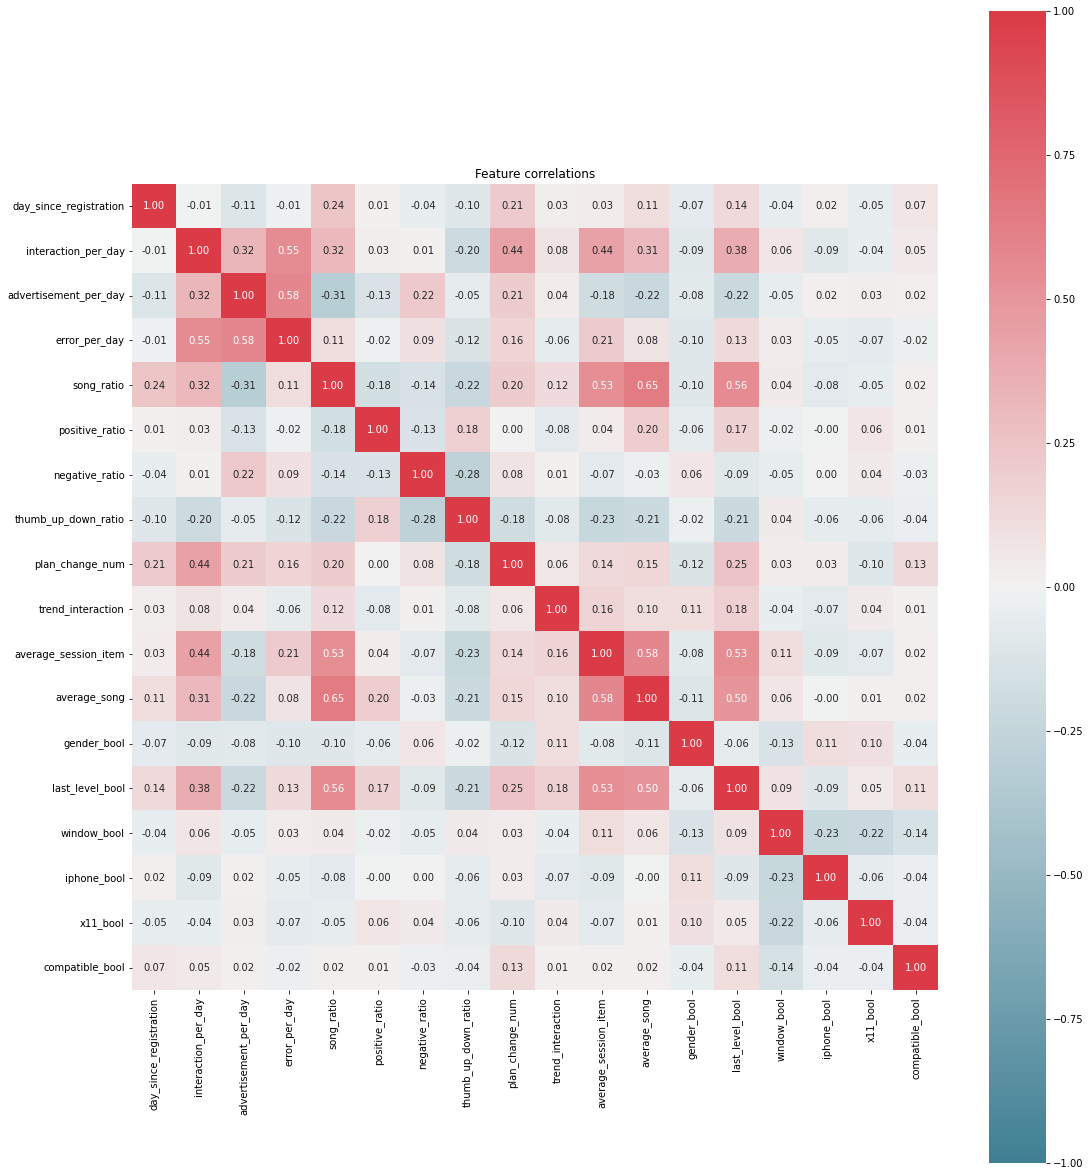

In [ ]:
correlation_matrix_2 = df_pd_engineered_feature[feature_column].corr()

# Plot correlations
plt.rcParams['figure.figsize'] = (20, 20)
plt.subplots_adjust(left = 0.20, right = 0.9, top = 0.95, bottom = 0.15)

sns.heatmap(correlation_matrix_2, \
            vmin = -1, \
            vmax = 1, \
            annot = True, \
            fmt='.2f', \
            cmap = sns.diverging_palette(220, 10, as_cmap = True), \
            square = True);
            
plt.title('Feature correlations');
plt.savefig('images/pic_3_4.png', bbox_inches='tight')

### 3.1.8_examine the effectiveness of engineered features

In addition to removing highly correlated features, through visualizations, we could examine if the features can help distinguish groups of churned and non-churned users and remove the less insightful features

Below are the FDE plots that show the relationship between engineered features and the binary response variable. In each figure, we can observe notable differences between the distributions of groups of churned and non-churned users. They suggest that all these selected features help identify if a particular user is churned or not. Therefore, no features were removed because of this analysis.

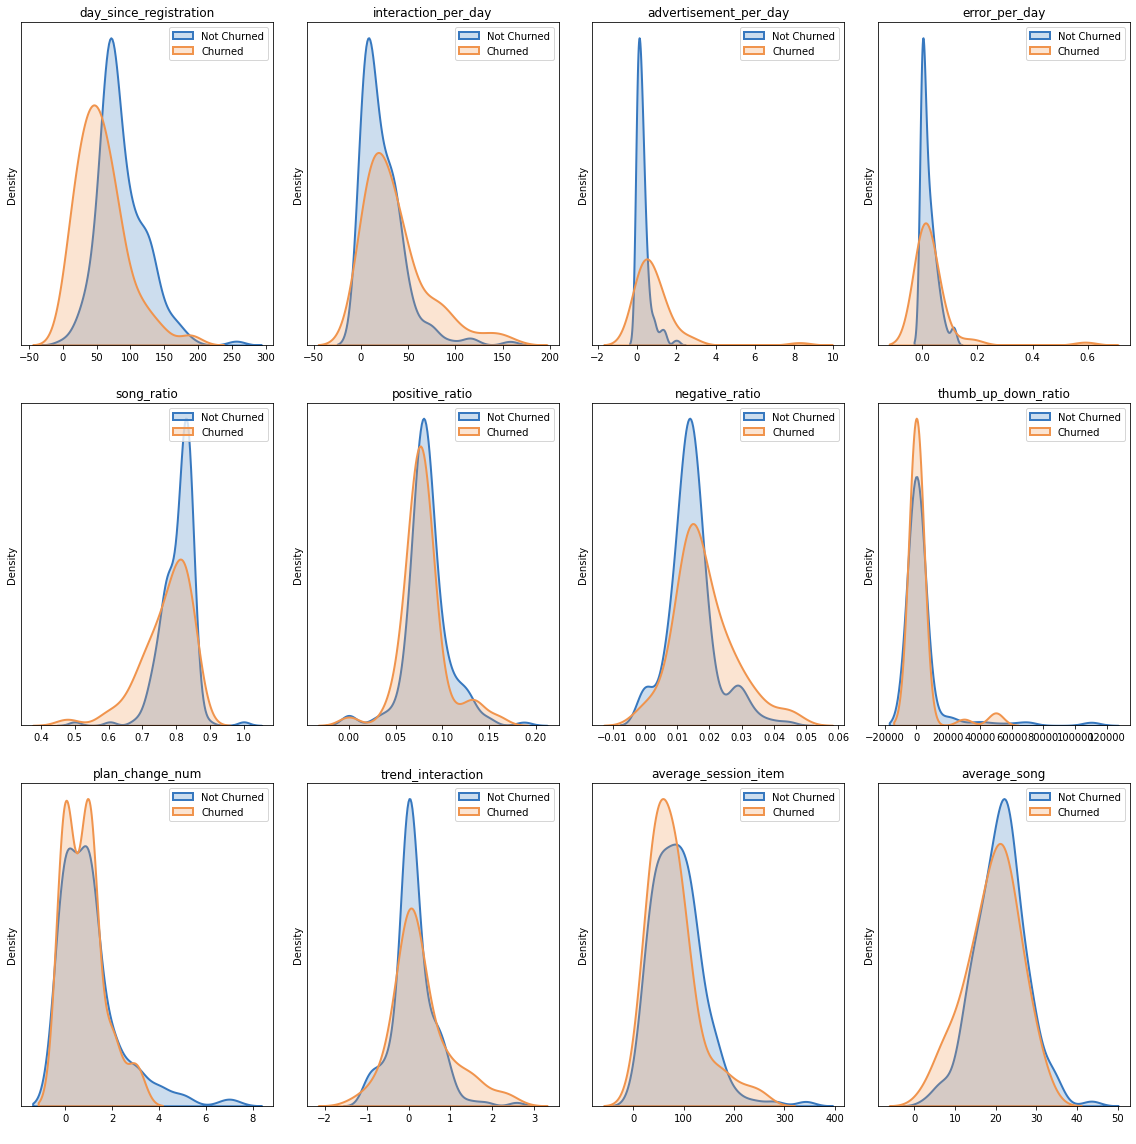

In [ ]:
# Plotting the relationship between numerical features and the binary response

# Numerical features
column_to_plot = \
['day_since_registration', 
 'interaction_per_day', 'advertisement_per_day', 'error_per_day', 
 'song_ratio', 'positive_ratio', 'negative_ratio', 'thumb_up_down_ratio', 
 'plan_change_num', 'trend_interaction', 
 'average_session_item', 'average_song']

# color settings
colors = ["windows blue", "faded orange"]
palette = sns.xkcd_palette(colors)
color_1 = palette[0]
color_2 = palette[1]

# figure size
plt.rcParams['figure.figsize'] = (16, 16)

# plotting
for i in range(len(column_to_plot)):

    plt.subplot(3, 4, i + 1)
    plt.tight_layout();

    sns.kdeplot(data = df_pd_engineered_feature[df_pd_engineered_feature['label'] == 0][column_to_plot[i]], \
                color = color_1, \
                shade = True,
                linewidth = 2);

    sns.kdeplot(data = df_pd_engineered_feature[df_pd_engineered_feature['label'] == 1][column_to_plot[i]], \
                color = color_2, \
                shade = True,
                linewidth = 2);

    plt.legend(['Not Churned','Churned']);
    plt.title(column_to_plot[i]);
    plt.xlabel(" ");
    plt.yticks([]);

plt.savefig('images/pic_3_5.png', bbox_inches='tight')

## 3.2_Modeling

With the dataset of engineered user-level features and labels from Section 3.1, we build and train a binary classifier to predict churned users.

In Section 3.2.1, we first randomly split the small dataset into the training set and the testing set (ratio of around 8:2). To be more precise, the training set has 177 data instances including 41 churned users and the testing set has 48 data instances including 11 churned users. The percentages of churned users in both train set and test set are also around 23.

Then, we defined pipelines (by functions in Section 3.2.2) and fit them on the train set with default hyperparameters. Ultimately, we evaluated their performance on the test set, using the PR-AUC and F1-score.

### 3.2.1_train-test split

In [ ]:
dataset = spark.createDataFrame(df_pd_engineered_feature[column_to_keep])

In [ ]:
dataset.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender_bool: long (nullable = true)
 |-- last_level_bool: long (nullable = true)
 |-- day_since_registration: double (nullable = true)
 |-- interaction_per_day: double (nullable = true)
 |-- advertisement_per_day: double (nullable = true)
 |-- error_per_day: double (nullable = true)
 |-- song_ratio: double (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- negative_ratio: double (nullable = true)
 |-- thumb_up_down_ratio: double (nullable = true)
 |-- plan_change_num: long (nullable = true)
 |-- trend_interaction: double (nullable = true)
 |-- average_session_item: double (nullable = true)
 |-- average_song: double (nullable = true)
 |-- window_bool: double (nullable = true)
 |-- iphone_bool: double (nullable = true)
 |-- x11_bool: double (nullable = true)
 |-- compatible_bool: double (nullable = true)



In [ ]:
dataset.drop('userId', 'label').printSchema()

root
 |-- gender_bool: long (nullable = true)
 |-- last_level_bool: long (nullable = true)
 |-- day_since_registration: double (nullable = true)
 |-- interaction_per_day: double (nullable = true)
 |-- advertisement_per_day: double (nullable = true)
 |-- error_per_day: double (nullable = true)
 |-- song_ratio: double (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- negative_ratio: double (nullable = true)
 |-- thumb_up_down_ratio: double (nullable = true)
 |-- plan_change_num: long (nullable = true)
 |-- trend_interaction: double (nullable = true)
 |-- average_session_item: double (nullable = true)
 |-- average_song: double (nullable = true)
 |-- window_bool: double (nullable = true)
 |-- iphone_bool: double (nullable = true)
 |-- x11_bool: double (nullable = true)
 |-- compatible_bool: double (nullable = true)



In [ ]:
# Train-test split
churn_train, churn_test = \
dataset.drop('userId').filter( dataset.label == 1 ).randomSplit([0.83, 0.17], seed = 40)

non_churn_train, non_churn_test = \
dataset.drop('userId').filter( dataset.label == 0 ).randomSplit([0.8, 0.2], seed = 40)

train_set = \
churn_train.union(non_churn_train)

test_set = \
churn_test.union(non_churn_test)

# Ensure that proportions of churned users in the train set and the test set 
# are similar
proportion_of_churned_train = churn_train.count() / train_set.count()
proportion_of_churned_test = churn_test.count() / test_set.count()

print(f'Number of churned users in train set: {churn_train.count()}', \
      f'\nNumber of churned users in test set: {churn_test.count()}')

print(f'\nNumber of non-churned users in train set: {non_churn_train.count()}', \
      f'\nNumber of non-churned users in test set: {non_churn_test.count()}')

print(f'\nproportion of churned users in the train set: {proportion_of_churned_train:.3f}', \
      f'\nproportion of churned users in the test set: {proportion_of_churned_test:.3f}')

print(f'\nOriginal dataset: {dataset.count()} rows', \
      f'\nTrain set and validation set: {train_set.count()} rows', \
      f'\nTest set: {test_set.count()} rows', \
      f'\nTrain:Test = {train_set.count() / dataset.count():.3f}:{test_set.count() / dataset.count():.3f}')

Number of churned users in train set: 41 
Number of churned users in test set: 11

Number of non-churned users in train set: 136 
Number of non-churned users in test set: 37

proportion of churned users in the train set: 0.232 
proportion of churned users in the test set: 0.229

Original dataset: 225 rows 
Train set and validation set: 177 rows 
Test set: 48 rows 
Train:Test = 0.787:0.213


### 3.2.2_pipeline functions [ train_and_eval(), train_model(), build_CV(), evaluate_model() ]

In [ ]:
def build_CV(classifier, paramGrid, feature_cols):
    '''
    Build a pipeline with or without the cross validation
    
    INPUT:
      classifier - a untrained machine learning classifier supported by Spark
      paramGrid (list) - a list of hyperparameters to search over
    
    OUTPUT:
      crossval (Pipeline/CrossValidator) - Pipeline or cross validator object
    '''
    # Configure a ML pipeline

    # it vectorizes the input features
    assembler = VectorAssembler(inputCols = feature_cols, \
                                outputCol = "rawFeatures")

    # it standardizes the numerical features
    scaler = StandardScaler(inputCol = "rawFeatures", \
                            outputCol = "scaledFeatures",\
                            withStd = True, \
                            withMean = True)

    # define a pipeline object
    pipeline = Pipeline(stages = [assembler, scaler, classifier])

    if paramGrid[0]:
        # define an object for cross validation
        crossval = CrossValidator( 
                                  estimator = pipeline,
                                  estimatorParamMaps = paramGrid,
                                  evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR'),
                                  numFolds = 3,
                                  seed = 40
        )

    else:
        crossval = pipeline

    return crossval

def train_model(classifier, train, paramGrid, feature_cols):
    '''
    Fit pipeline or cross validator that have a machine learning classifier
    
    INPUT:
      classifier - untrained machine learning classifier
      paramGrid (list) - a list of hyperparameters to search over
      train (Spark dataframe) - train set
    
    OUTPUT:
      model (PipelineModel / CrossValidatorModel) - a trained machine learning model
      training_time (float) - training time
    '''
    cross_val = build_CV(classifier, paramGrid, feature_cols) # obtain the object to be trained
    start = time()
    model = cross_val.fit(train) # train the model with the train set
    end = time()
    training_time = end - start

    return model, training_time

In [ ]:
def evaluate_model(model, data, prob = False):
    '''
    Evaluate the trained model
    
    INPUT:
      model (PipelineModel / CrossValidatorModel) - a trained machine learning model
      data (Spark dataframe) - training set or testing set
    
    OUTPUT:
      evalMetrics (dict): disctionary of evaluation metrics
    '''
    start = time()
    pred = model.transform(data) # make prediction

    # define evaluators
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol = "probability", labelCol = "label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label")

    evaluator_areaUnderPR = BinaryClassificationEvaluator(metricName = 'areaUnderPR')

    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["areaUnderPR"] = evaluator_areaUnderPR.evaluate(pred)
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

In [ ]:
# lump all steps together
def train_and_eval(classifier, train, test, paramGrid, feature_cols):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT:
      classifier - a untrained machine learning classifier
      train (Spark dataframe) - train set
      test (Spark dataframe) - test set
      paramGrid (list) - a list of hyperparameters to search over
    
    OUTPUT:
      evalMetrics (dict) - dictionary of evaluation metrics, 
      summary (Spark dataframe) - table of evaluation metrics
      model (PipelineModel / CrossValidatorModel) - trained machine learning model
    '''
    # train the model
    model, training_time = train_model(classifier, train, paramGrid, feature_cols)
    
    # evaluate model performance
    eval_Metrics_Training = evaluate_model(model, train)
    eval_Metrics_Testing = evaluate_model(model, test)

    # compile metrics
    evalMetrics = {}
    evalMetrics['PR_train'] = eval_Metrics_Training['areaUnderPR']
    evalMetrics['f1_train'] = eval_Metrics_Training['f1']
    evalMetrics['PR_test'] = eval_Metrics_Testing['areaUnderPR']
    evalMetrics['f1_test'] = eval_Metrics_Testing['f1']

    evalMetrics['confusion_matrix_test'] = eval_Metrics_Testing['confusion_matrix']

    evalMetrics['train_time'] = training_time
    evalMetrics['pred_time'] = eval_Metrics_Training['prediction_time'] \
                               + eval_Metrics_Testing['prediction_time']

    # convert metrics into a Spark dataframe
    metrics_to_display = \
    {
        k:round(v, 4) for k, v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns = metrics_to_display.keys()))
    
    return evalMetrics, summary, model

### 3.2.3_train classifiers with default hyperparameters

#### 3.2.3.0_determine input futures

In [ ]:
# Define input feature columns for the model training
feature_cols = dataset.drop('label', 'userId').columns
               
feature_cols

['gender_bool',
 'last_level_bool',
 'day_since_registration',
 'interaction_per_day',
 'advertisement_per_day',
 'error_per_day',
 'song_ratio',
 'positive_ratio',
 'negative_ratio',
 'thumb_up_down_ratio',
 'plan_change_num',
 'trend_interaction',
 'average_session_item',
 'average_song',
 'window_bool',
 'iphone_bool',
 'x11_bool',
 'compatible_bool']

#### 3.2.3.1_evaluation functions [ start_train(), plot_pr(), print_coefficient_importance() ]

In [ ]:
def plot_pr(model):
  '''
  Plot the trained model's PR-curve of the train set
  
  INPUT:
    model (PipelineModel / CrossValidatorModel) - a trained machine learning model
  
  OUTPUT: None
  '''

  # obtain the summary of the model trainning process & the values for plotting PR-curve
  try:
    training_summary = model.stages[-1].summary
    pr_curve = training_summary.pr.toPandas()

  except:
    training_summary = model.stages[-1].summary()
    pr_curve = training_summary.pr.toPandas()
  
  # set the figure size
  plt.rcParams['figure.figsize'] = (8, 8)

  # plotting
  plt.plot(pr_curve['precision'], pr_curve['recall'])

  # label & title formatting
  plt.ylabel('precision')
  plt.xlabel('recall')
  plt.title('PR Curve')

In [ ]:
def return_coefficient_importance(model, 
                                 is_coeff = True, 
                                 feature_name = feature_cols):
  '''
  Return the feature coefficients or importance of the trained model
  
  INPUT:
    model (PipelineModel / CrossValidatorModel) - a trained machine learning model
    is_coeff (bool) - tell the function if it can find feature coefficients 
                     from the trained model
  
  OUTPUT:
    df_pd_coefficient_importance (pandas dataframe) - dataframe of feature 
                                                      coefficients or importance 
  '''
  # get the values of feature coefficients or importances
  coeff_or_feature_importance = \
  model.stages[-1].coefficients if is_coeff else model.stages[-1].featureImportances

  # convert the values of feature coefficients or importances into a list
  list_temp = [coeff_or_feature_importance[i] for i in range(len(coeff_or_feature_importance))]

  # convert the list of feature coefficients or importances into pandas dataframe
  df_pd_coefficient_importance = \
  pd.DataFrame({"feature": feature_name, "coefficient": list_temp})\
              .sort_values('coefficient', ascending = False)

  return df_pd_coefficient_importance

In [ ]:
def start_train(classifier, 
                text,
                train = train_set,
                test = test_set,
                feature_cols = feature_cols,
                param_grid = ParamGridBuilder().build()):
  '''
  Starter function for training a classifier
  
  INPUT:
    classifier - a untrained machine learning classifier supported by Spark
    text (str) - name of the classifier
    train (Spark dataframe) - train set
    test (Spark dataframe) - test set
    feature_cols (list) - a list of features for training the model
    paramGrid (list) - a list of hyperparameters to search over
  
  OUTPUT:
    best_model - the trained model
    eval_metric (dict) - dictionary of evaluation metrics
    summary (Spark dataframe) - table of evaluation metrics
  '''
  # start training the input classifier
  eval_metric, summary, model = \
  train_and_eval(classifier, train, test, param_grid, feature_cols)

  if param_grid[0]:
      best_model = model.bestModel # save the best model

  else:
      best_model = model

  #sShow metrics
  print(text, ':')
  summary.show()

  return best_model, eval_metric, summary

#### 3.2.3.2_train five different classifiers

In [ ]:
# Train and evaluate the logistic regression
classifier_LR = \
LogisticRegression(labelCol = "label", 
          featuresCol = "scaledFeatures")

best_model_LR, eval_metric_LR, summary_LR = \
start_train(classifier = classifier_LR,
            text = 'Logistic Regression')

Logistic Regression :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7708|  0.8825| 0.7045| 0.8272|    3.8547|   0.2128|
+--------+--------+-------+-------+----------+---------+



In [ ]:
# Train and evaluate the support vector machine
classifier_SVM = \
LinearSVC(labelCol = "label", 
          featuresCol = "scaledFeatures")

best_model_SVM, eval_metric_SVM, summary_SVM = \
start_train(classifier = classifier_SVM, \
            text = 'Support Vector Machine')


Support Vector Machine :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7634|  0.8954| 0.7292| 0.8455|    11.111|    0.177|
+--------+--------+-------+-------+----------+---------+



In [ ]:
# Train and evaluate the multilayer perceptron classifier
classifier_MLP = \
MultilayerPerceptronClassifier(labelCol = "label", 
                               featuresCol = "scaledFeatures",
                               layers = [18, 2])

best_model_MLP, eval_metric_MLP, summary_MLP = \
start_train(classifier = classifier_MLP, \
            text = 'Multilayer Perceptron')

Multilayer Perceptron :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.5309|  0.8583| 0.4319| 0.8198|     3.602|   0.3222|
+--------+--------+-------+-------+----------+---------+



In [ ]:
# Train and evaluate the random forest classifier
classifier_RF = \
RandomForestClassifier(labelCol = "label", 
                       featuresCol = "scaledFeatures")

best_model_RF, eval_metric_RF, summary_RF = \
start_train(classifier = classifier_RF, \
            text = 'Random Forest')

Random Forest :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.9796|  0.9651| 0.4385| 0.7572|    2.2077|   0.1808|
+--------+--------+-------+-------+----------+---------+



In [ ]:
# Train and evaluate the gradient-boosted trees classifier
classifier_GBT = \
GBTClassifier(labelCol = "label", 
              featuresCol = "scaledFeatures")

best_model_GBT, eval_metric_GBT, summary_GBT = \
start_train(classifier = classifier_GBT, \
            text = 'Gradient-Boosted Tree')

Gradient-Boosted Tree :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|     1.0|     1.0| 0.4662| 0.7245|     9.874|   0.1969|
+--------+--------+-------+-------+----------+---------+



### 3.2.4_summary of initial model evaluation

Below summarizes the performance of the selected classifiers trained with default hyperparameters. SVMhad the highest PR-AUC score of the test set. LR took second place respectively. The difference between them was around 0.025. However, considering LR’s 3.12 times faster training time, LR was chosen to proceed to the fine-tunning step.


In [ ]:
# Print training results of above trained classifiers
list_summary = [summary_LR, summary_SVM, summary_MLP, summary_RF, summary_GBT]
list_classifier = ['Logistic Regression', 'Support Vector Machine', 
                   'Multilayer Perceptron', 
                   'Random Forest', 'Gradient-Boosted Tree']

for i in range(len(list_summary)):

  print(list_classifier[i], ':')
  list_summary[i].show()

Logistic Regression :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7708|  0.8825| 0.7045| 0.8272|    3.8547|   0.2128|
+--------+--------+-------+-------+----------+---------+

Support Vector Machine :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7634|  0.8954| 0.7292| 0.8455|    11.111|    0.177|
+--------+--------+-------+-------+----------+---------+

Multilayer Perceptron :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.5309|  0.8583| 0.4319| 0.8198|     3.602|   0.3222|
+--------+--------+-------+-------+----------+---------+

Random Forest :
+--------+--------+-------+-------+----------+---------

### 3.2.5_refinement - logistic regression

#### 3.2.5.1_grid search

We can further improve the selected classifier by tuning the hyperparameters using the grid search. Having the pipeline with the selected classifier, we pass the pre-set hyperparameters list and the pipeline into the CrossValidator() object with 3-fold cross validation using PR-AUC. Cross validation will validate the robustness of the trained models. When the best hyperparameters are determined, the model will be re-trained on the entire train set. We could check out the improvement by looking at the PR-AUC score of the test set.

In [ ]:
# Refine the logistic regression model by grid searching
classifier_LR_grid = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures")

# define hyperparameters to search over
param_grid = \
ParamGridBuilder().addGrid(classifier_LR_grid.regParam, [0, 0.01, 0.02, 0.03])\
                  .addGrid(classifier_LR_grid.elasticNetParam, [0])\
                  .addGrid(classifier_LR_grid.maxIter, [10, 20, 30])\
                  .build()

# train and evaluate the model
best_model_LR_grid, eval_metric_LR_grid, summary_LR_grid = \
start_train(classifier = classifier_LR_grid,
            text = 'Logistic Regression (grid search)',
            param_grid = param_grid)

best_model_stage_3 = best_model_LR_grid.stages[2]
print('Best combination of hyperparameters:')
print('elasticNetParam: ', best_model_stage_3.extractParamMap()[best_model_stage_3.elasticNetParam])
print('regParam: ', best_model_stage_3.extractParamMap()[best_model_stage_3.regParam])
print('maxIter: ', best_model_stage_3.extractParamMap()[best_model_stage_3.maxIter])

Logistic Regression (grid search) :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7671|   0.837| 0.7273| 0.8191|   63.9629|   0.2022|
+--------+--------+-------+-------+----------+---------+

Best combination of hyperparameters:
elasticNetParam:  0.0
regParam:  0.03
maxIter:  10


In [ ]:
is_L2 = best_model_stage_3.extractParamMap()[best_model_stage_3.elasticNetParam]
reg_param = best_model_stage_3.extractParamMap()[best_model_stage_3.regParam]
max_iter = best_model_stage_3.extractParamMap()[best_model_stage_3.maxIter]

#### 3.2.5.2_remove less important features

Too many features could lead to the overfitting problem. Some classification algorithm provides information about the importance of features, e.g., coefficients in LR or feature importance in RF. We could improve the model’s generalization by re-train the model with more important features only. To be more specific, we could remove the features one by one starting from the least important one and re-train the model with the modified dataset. We could choose the optimal feature combination that gives rise to the highest PR-AUC score of train and test set.

In [ ]:
# display the values of feature coefficients in descending order
df_coeff = return_coefficient_importance(model = best_model_LR_grid, is_coeff = True)
df_coeff.reset_index(drop = True)

,feature,coefficient
0,advertisement_per_day,0.714841
1,interaction_per_day,0.605997
2,negative_ratio,0.392914
3,last_level_bool,0.298522
4,trend_interaction,0.147613
5,gender_bool,0.093694
6,x11_bool,0.057516
7,iphone_bool,0.034051
8,average_session_item,-0.026071
9,thumb_up_down_ratio,-0.035983


In [ ]:
# display the absolute values of feature coefficients in descending order
df_coeff['coefficient'] = abs(df_coeff['coefficient'])
df_coeff = df_coeff.sort_values(by = ['coefficient'], ascending = False).reset_index(drop = True)
df_coeff

,feature,coefficient
0,advertisement_per_day,0.714841
1,day_since_registration,0.615178
2,interaction_per_day,0.605997
3,song_ratio,0.470308
4,plan_change_num,0.432320
5,negative_ratio,0.392914
6,last_level_bool,0.298522
7,compatible_bool,0.235870
8,error_per_day,0.180246
9,trend_interaction,0.147613


In [ ]:
# Identify the model having highest PR_test and using less input features
# Then, identify the corresponding input features
classifier_LR_remove = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures")

# adopt the best combination of hyperparameters found by grid searching
classifier_LR_remove.setParams(elasticNetParam = 0, regParam = 0.03, maxIter = 10)

feature_col_reduced = feature_cols.copy()
coeff_list = df_coeff['feature'].tolist()

for i in range(len(coeff_list)):

  feature_col_reduced.remove(coeff_list[- 1 - i])

  # Train the model and evaluate performance
  best_model_LR_remove, eval_metric_LR_remove, summary_LR_remove = \
  start_train(classifier = classifier_LR_remove, \
              text = f"Logistic Regression_remove_{i} with {feature_col_reduced}",
              feature_cols = feature_col_reduced)
  
  if len(feature_col_reduced) == 1: break

Logistic Regression_remove_0 with ['gender_bool', 'last_level_bool', 'day_since_registration', 'interaction_per_day', 'advertisement_per_day', 'error_per_day', 'song_ratio', 'positive_ratio', 'negative_ratio', 'thumb_up_down_ratio', 'plan_change_num', 'trend_interaction', 'average_song', 'window_bool', 'iphone_bool', 'x11_bool', 'compatible_bool'] :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7704|   0.837| 0.7227| 0.8191|    1.7389|   0.1477|
+--------+--------+-------+-------+----------+---------+

Logistic Regression_remove_1 with ['gender_bool', 'last_level_bool', 'day_since_registration', 'interaction_per_day', 'advertisement_per_day', 'error_per_day', 'song_ratio', 'positive_ratio', 'negative_ratio', 'thumb_up_down_ratio', 'plan_change_num', 'trend_interaction', 'average_song', 'window_bool', 'x11_bool', 'compatible_bool'] :
+--------+--------+------

In [ ]:
# best combination of input features
# from the model named Logistic Regression_remove_4
# because both PR_train and PR_test slightly increase
feature_col_reduced =  \
['gender_bool', 'last_level_bool', 'day_since_registration', \
 'interaction_per_day', 'advertisement_per_day', 'error_per_day', \
 'song_ratio', 'positive_ratio', 'negative_ratio', \
 'plan_change_num', 'trend_interaction', 'window_bool', 'compatible_bool']

In [ ]:
# Train and evaluate model 
# with the best combination of hyperparameters found by grid search
# without less important features
classifier_LR_remove = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures")

classifier_LR_remove.setParams(elasticNetParam = is_L2, regParam = reg_param, maxIter = max_iter)

best_model_LR_remove, eval_metric_LR_remove, summary_LR_remove = \
start_train(classifier = classifier_LR_remove,
            text = 'Logistic Regression (remove less important features)',
            feature_cols = feature_col_reduced)

print('The features remain:\n')
feature_col_reduced

Logistic Regression (remove less important features) :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|   0.776|  0.8444| 0.7296| 0.8013|    1.1366|   0.1699|
+--------+--------+-------+-------+----------+---------+

The features remain:



['gender_bool',
 'last_level_bool',
 'day_since_registration',
 'interaction_per_day',
 'advertisement_per_day',
 'error_per_day',
 'song_ratio',
 'positive_ratio',
 'negative_ratio',
 'plan_change_num',
 'trend_interaction',
 'window_bool',
 'compatible_bool']

#### 3.2.5.3_weighted classes

To recall, the ratio of classes in the dataset is imbalanced. By default, the machine algorithms consider each class as equal. We can handle class imbalance by assigning different weights to the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher weight, and meanwhile, reducing weight for the majority class. In turn, the PR-AUC scores could be improved.

For binary classification problems, the standard practice is assigning the rate of major class as the weight of the minor class. In this case, we could assign 0.23 and 0.77 to the non-churned class and churned class respectively.


In [ ]:
# Assign different class weights to class 0 and class 1
cal_weight = udf(lambda x: 0.23 if x == 0 else 0.77, DoubleType())

train_set_weighted = train_set.withColumn('class_weight', cal_weight('label'))

In [ ]:
# Train and evaluate the model
# with the best combination of hyperparameters found by grid search
# without less important features
# with unequal class weights
classifier_LR_weighted = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures",
                   weightCol = 'class_weight')

classifier_LR_weighted.setParams(elasticNetParam = is_L2, regParam = reg_param, maxIter = max_iter)

best_model_LR_weighted, eval_metric_LR_weighted, summary_LR_weighted = \
start_train(classifier = classifier_LR_weighted, \
            text = 'Logistic Regression (classes with weights)',
            feature_cols = feature_col_reduced,
            train = train_set_weighted)

Logistic Regression (classes with weights) :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7718|  0.8641| 0.7345|  0.838|    1.3649|   0.1872|
+--------+--------+-------+-------+----------+---------+



#### 3.2.5.4_threshold

For these five classifiers, to do the prediction, they generate a probability of how likely an instance is a churned user and classify it correspondingly depending on the probability value and the threshold. There is a sweet point where the model can reach the highest F1-score and it is not necessarily the default threshold value, 0.5. In light of this, we could optimize the model by figuring out the optimal threshold value. With this optimal threshold, we could treat the corresponding F1-score of the test set as the final evaluation.



In [ ]:
# Find the optimal threshold
train_summary_LR_weighted = best_model_LR_weighted.stages[-1].summary
f_measure = train_summary_LR_weighted.fMeasureByThreshold
max_f_measure = f_measure.groupBy().max('F-Measure').select('max(F-Measure)').head()

best_threshold_LR_weighted = \
f_measure.where(f_measure['F-Measure'] == max_f_measure['max(F-Measure)']) \
     .select('threshold').head()['threshold']

print(f'Optimal Thershold: {best_threshold_LR_weighted}')

Optimal Thershold: 0.5590469033209664


In [ ]:
# Train and evaluate the model 
# with the best combination of hyperparameters found by grid search
# without less important features
# with unequal class weights
# with the optimal threshold
classifier_LR_threshold = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures",
                   weightCol = 'class_weight',
                   threshold = best_threshold_LR_weighted)

classifier_LR_threshold.setParams(elasticNetParam = is_L2, regParam = reg_param, maxIter = max_iter)

best_model_LR_threshold, eval_metric_LR_threshold, summary_LR_threshold = \
start_train(classifier = classifier_LR_threshold, \
            text = 'Logistic Regression (optimal threshold)',
            feature_cols = feature_col_reduced,
            train = train_set_weighted)

Logistic Regression (optimal threshold) :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7718|  0.8743| 0.7345| 0.8563|    1.2002|   0.2113|
+--------+--------+-------+-------+----------+---------+



#### Sum up: <br>
It is noticeable that the PR-AUC of the test set was keep improving when new measures were applied. Compared to model refined by grid search only, the last refined model's PR-AUC of the test set was increased by 3%. Given that all implementations for refinement showed improvement, all these measures were adopted for tuning the model trained on the full 12GB dataset.

# **Section 4: Final Evaluation (mini dataset)** 

According to the PR-AUC score of the testing set, we selected the best classification algorithm to train and test on the full 12GB dataset, using Amazon’s EMR cluster. 

In [ ]:
# Define the classifer for final evaluation
classifier_LR_final = \
LogisticRegression(labelCol = "label", 
                   featuresCol = "scaledFeatures",
                   weightCol = 'class_weight')

In [ ]:
# Adopt the hyperparameters found by grid saerching
classifier_LR_final.setParams(elasticNetParam = is_L2, regParam = reg_param, maxIter = max_iter);

In [ ]:
# input the more important features only
feature_col_reduced =  \
['gender_bool', 'last_level_bool', 'day_since_registration', \
 'interaction_per_day', 'advertisement_per_day', 'error_per_day', \
 'song_ratio', 'positive_ratio', 'negative_ratio', \
 'plan_change_num', 'trend_interaction', 'window_bool', 'compatible_bool']

In [ ]:
# Assign different weights(class_0:class_1 = 0.23:0.77) to the classes
cal_weight = udf(lambda x: 0.23 if x == 0 else 0.77, DoubleType())

train_set_weighted = train_set.withColumn('class_weight', cal_weight('label'))

In [ ]:
# Adopt the optimal threshold for the train set, which is 0.559
classifier_LR_final.setParams(threshold = best_threshold_LR_weighted);

In [ ]:
# Train the model and evaluate performance

best_model_LR_final, eval_metric_LR_final, summary_LR_final = \
start_train(classifier = classifier_LR_final, \
            text = 'Logistic Regression (final)',
            feature_cols = feature_col_reduced,
            train = train_set_weighted)

# confusion matrix
print('Confusion matrix:')
eval_metric_LR_final['confusion_matrix_test'].show()


print('Setting for refinement:\n')

best_model_stage_3 = best_model_LR_final.stages[2]
print('   -Hyperparameters selected by grid searching:')
print('       elasticNetParam: ', best_model_stage_3.extractParamMap()[best_model_stage_3.elasticNetParam])
print('       regParam: ', best_model_stage_3.extractParamMap()[best_model_stage_3.regParam])
print('       maxIter: ', best_model_stage_3.extractParamMap()[best_model_stage_3.maxIter], '\n')

print('   -Class weights (class 0 : class 1): 0.23:0.77 \n')

print(f'   -Optimal Threshold: {best_threshold_LR_weighted:.3f}', '\n')

print('   -The features remain:')
for i in feature_col_reduced:
  print(f'      {i}')

Logistic Regression (final) :
+--------+--------+-------+-------+----------+---------+
|PR_train|f1_train|PR_test|f1_test|train_time|pred_time|
+--------+--------+-------+-------+----------+---------+
|  0.7718|  0.8743| 0.7345| 0.8563|    1.2263|   0.1428|
+--------+--------+-------+-------+----------+---------+

Confusion matrix:
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    0| 33|  4|
|    1|  3|  8|
+-----+---+---+

Setting for refinement:

   -Hyperparameters selected by grid searching:
       elasticNetParam:  0.0
       regParam:  0.03
       maxIter:  10 

   -Class weights (class 0 : class 1): 0.23:0.77 

   -Optimal Threshold: 0.559 

   -The features remain:
      gender_bool
      last_level_bool
      day_since_registration
      interaction_per_day
      advertisement_per_day
      error_per_day
      song_ratio
      positive_ratio
      negative_ratio
      plan_change_num
      trend_interaction
      window_bool
      compatible_bool


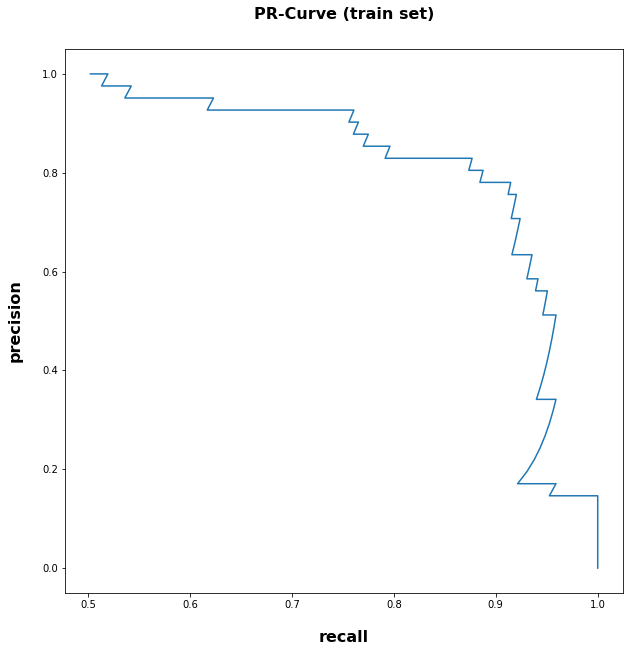

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_pr(best_model_LR_final)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 30
ax.set_xlabel('recall', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_ylabel('precision', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title("PR-Curve (train set)", \
             fontdict = label_fontdict, \
             pad = pad);

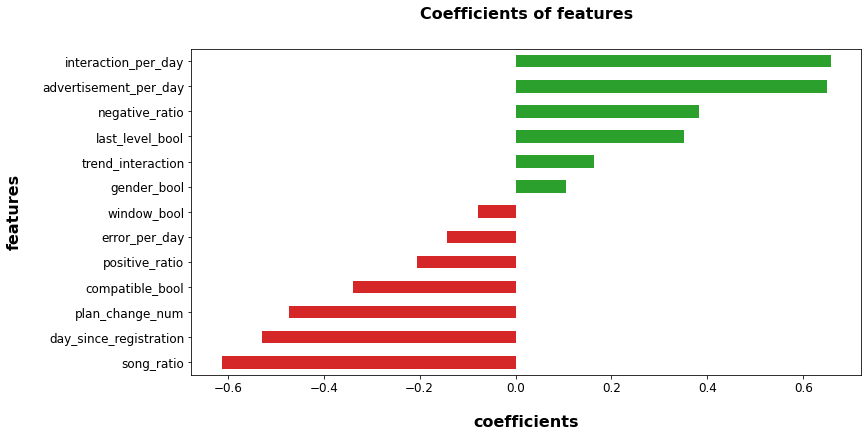

In [ ]:
df_coeff = \
return_coefficient_importance(model = best_model_LR_final, \
                              is_coeff = True, \
                              feature_name = feature_col_reduced).reset_index(drop = True)

fig, ax = plt.subplots(figsize=(12, 6))

df_coeff['>0?'] = df_coeff.coefficient > 0
df_coeff['color'] = df_coeff['>0?'].map({True: 'tab:green', False: 'tab:red'})
df_coeff.sort_values(by = ['coefficient'], inplace = True)
df_coeff.set_index(['feature'], drop = True, inplace = True)

df_coeff.coefficient.plot.barh(color = df_coeff['color'], \
                               fontsize = 12, \
                               legend = False);

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 30
ax.set_xlabel('coefficients', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_ylabel('features', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title("Coefficients of features", \
             fontdict = label_fontdict, \
             pad = pad);